In [42]:
Packages <- c("dplyr","cubature", "pracma","data.table", "gridExtra","viridis", "ggsignif", "broom", "ggpubr", "caret","cowplot","ggplot2","fields","bbmle", "dplyr", "tidyr", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/kernel_fitting/')

load("~/parentage/r_data/site_dist_info.RData")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_grid_search.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0

__NB bbmle( ) minimizes the negative log-likelihood rather than maximizing the log-likelihood__

__"As I told you earlier, searching for the mle is a bit of an art. You are bound to occasionally encounter, 
shall I say, difficulties, getting reliable estimates. Maximum likelihood is an extremely powerful and 
flexible approach to parameter estimation, and power and flexibility never come free. They are paid for 
with suffering. Here are a few problems that are likely. You will discover others." The Ecological Detective__

__optimize for both theta and k simultaneously, with bbmle and grid search. Use grid search results because that's where the CIs come from, but use bbmle results to sanity check grid search results.__

In [120]:
#specify upper and lower bounds for parameters
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/parentage_matrix16_corrected.csv", header=FALSE))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp16.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index16.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))


sum(Assignments)

a=-10
b=10
n_par_16 <- sum(Assignments[1:length(Sampled_reefs),])
n_offs_16 <- sum(Assignments)

x <- list(Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions) #put inputs into a list because that's the bbmle format

fit_both16 <- suppressWarnings(mle2(LL_kt_bbmle, start=list(k=-3, theta=1), lower=c(-10, 0.15), upper=c(10, 8), method="L-BFGS-B", data=x, control=list(maxit=500)))
fit_both16


[1] 111


Call:
mle2(minuslogl = LL_kt_bbmle, start = list(k = -3, theta = 1), 
    method = "L-BFGS-B", data = x, lower = c(-10, 0.15), upper = c(10, 
        8), control = list(maxit = 500))

Coefficients:
        k     theta 
-3.102303  8.000000 

Log-likelihood: -38.64 

### Use a grid search, write out the profiles, and use those to compute confidence intervals. Plot likelihood surfaces

In [72]:
Assignments <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/parentage_matrix14_corrected.csv", header=FALSE))
Adult_sample_proportions <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/prop_samp14.csv", header=FALSE))
Sampled_reefs <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/site_index14.csv", header=FALSE))
Distances <- as.matrix(read.csv("~/parentage/kernel_fitting/1340_loci/input/distance_matrix_unsurveyed.csv", header=FALSE))
Reef_sizes <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.csv", header=FALSE))
Centroids <- as.matrix(read.csv("~/parentage/kernel_fitting/894_loci/centroids_unsurveyed.csv", header=T))


# use a grid search to find k that minimizes the log likelihood
k_eval <- c(seq(from=-10, to=10, by=0.01))
theta_eval <- c(seq(from=0.1, to=5, by=.01))
nll_matrix <- matrix(data=NA, nrow=length(k_eval), ncol=length(theta_eval), 
                     dimnames=list(k_eval, theta_eval))
pb <- txtProgressBar(min = 0, max = length(k_eval), style = 3)#7 years in each interation

#Begin grid search: i <- 1; j <- 1
for(i in 1:length(k_eval)){
  k <- k_eval[i]
  for(j in 1:length(theta_eval)){
    theta <- theta_eval[j]
    nll_matrix[i,j] <- LL_kt_grid(k=k, theta=theta, Distances=Distances, Assignments=Assignments, Sampled_reefs=Sampled_reefs, Reef_sizes=Reef_sizes, Adult_sample_proportions=Adult_sample_proportions)
  }
    setTxtProgressBar(pb, i)

}


close(pb)

max(nll_matrix, na.rm = T)
min(nll_matrix, na.rm = T)

sum(is.na(nll_matrix)==T)
best_params_index <- which(nll_matrix == min(nll_matrix, na.rm = T), arr.ind=TRUE)
best_params <- c(k_eval[best_params_index[1]], theta_eval[best_params_index[2]])
best_params


#write profile results
write.csv(nll_matrix, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_2014.csv", row.names=T, quote=FALSE)



  |======================================================================| 100%


[1] 342.0399

[1] 82.3131

[1] 0

[1] 0.49 0.38

In [79]:
#profile CIs
profile_18 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile_2018.csv", header=T) %>%
  rename(k_eval= "X") 

#df
profile_18_df <- profile_18%>%
    gather(2:492, key="theta_eval", value="log_like")

#get rid of the X that read.csv inserted
profile_18_df$theta_eval <- gsub("X","", profile_18_df$theta_eval, fixed=T)
profile_18_df$theta_eval <- as.numeric(profile_18_df$theta_eval)
#find best fit
best_fit_18 <- profile_18_df %>%
    filter(log_like==min(log_like))

#find 95% CI, using instructions from Ben Bolker's Ecological Models in R and https://public.wsu.edu/~jesse.brunner/classes/bio572/Lab6_Likelihood.html
best_ll_18 <- as.numeric(best_fit_18$log_like)
best_k_18 <- as.numeric(best_fit_18$k_eval)
best_theta_18 <- as.numeric(best_fit_18$theta_eval)
cutoff_18 <- best_ll_18 + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate

#pull out the values below the cutoff
profile_18_df95 <- profile_18_df %>% 
        filter(log_like < cutoff_18) 

lower_profile_18 <- profile_18_df95 %>%
    filter(k_eval <= best_k_18 & theta_eval <= best_theta_18)


#pull out the values above the cutoff
upper_profile_18 <- profile_18_df95 %>%
    filter(k_eval >= best_k_18 & theta_eval >= best_theta_18)

upper_18 <- upper_profile_18 %>%
    filter(log_like== max(log_like))
lower_18 <- lower_profile_18 %>%
    filter(log_like== max(log_like))

upper_k_18 <- as.numeric(upper_18 %>%
                          select(k_eval))
upper_theta_18 <- as.numeric(upper_18 %>%
                          select(theta_eval))
lower_k_18 <- as.numeric(lower_18 %>%
                          select(k_eval))
lower_theta_18 <- as.numeric(lower_18 %>%
                          select(theta_eval))
upper_k_18
lower_k_18

upper_theta_18
lower_theta_18

best_k_18
best_theta_18

mdd18 <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=best_k_18, theta=best_theta_18, , method = "pcubature")$integral

write.csv(profile_18_df95, file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/profile95CI_2018.csv", row.names=F, quote=FALSE)


[1] 4.06

[1] 3.59

[1] 0.24

[1] 0.2

[1] 4.04

[1] 0.22

In [33]:
best_k_all
best_theta_all


[1] -2.51

[1] 1.49

In [ ]:
#read back in if just plotting contours. 
profile_12_df <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_searc/profile_2012.csv", header=T) %>%
  rename(k_eval= "X")
profile_12_df <- profile_12_df %>%
    gather(2:792, key="theta_eval", value="log_like")

#get rid of the X that read.csv inserted
profile_12_df$theta_eval <- gsub("X","", profile_12_df$theta_eval, fixed=T)
profile_12_df$theta_eval <- as.numeric(profile_12_df$theta_eval)


In [ ]:
#gather profiles from all years to combine into a LL surface plot
profile12_df95 <- profile_12_df %>% 
    filter(log_like < cutoff_12)%>%
    mutate(year="2012")  %>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)



profile13_df95 <- profile_13_df %>% 
    filter(log_like < cutoff_13)%>%
    mutate(year="2013") %>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)



profile14_df95 <- profile_14_df %>% 
    filter(log_like < cutoff_14)%>%
    mutate(year="2014")%>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)



profile15_df95 <- profile_15_df %>% 
    filter(log_like < cutoff_15)%>%
    mutate(year="2015")%>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)




profile16_df95 <- profile_16_df %>% 
    filter(log_like < cutoff_16)%>%
    mutate(year="2016") %>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)




profile17_df95 <- profile_17_df %>% 
    filter(log_like < cutoff_17)%>%
    mutate(year="2017")%>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)



profile18_df95 <- profile_18_df %>% 
    filter(log_like < cutoff_18)%>%
    mutate(year="2018") %>%
    sample_frac(0.1)  %>%
    filter(k_eval <10 & k_eval >-10)

profiles_df <- bind_rows(profile12_df95,profile14_df95, profile13_df95, profile18_df95,profile15_df95, profile16_df95, profile17_df95) %>%
    filter(theta_eval <=5)



In [28]:
profile_all_df95 <- profile_all_df %>% 
        filter(log_like < cutoff_all) 


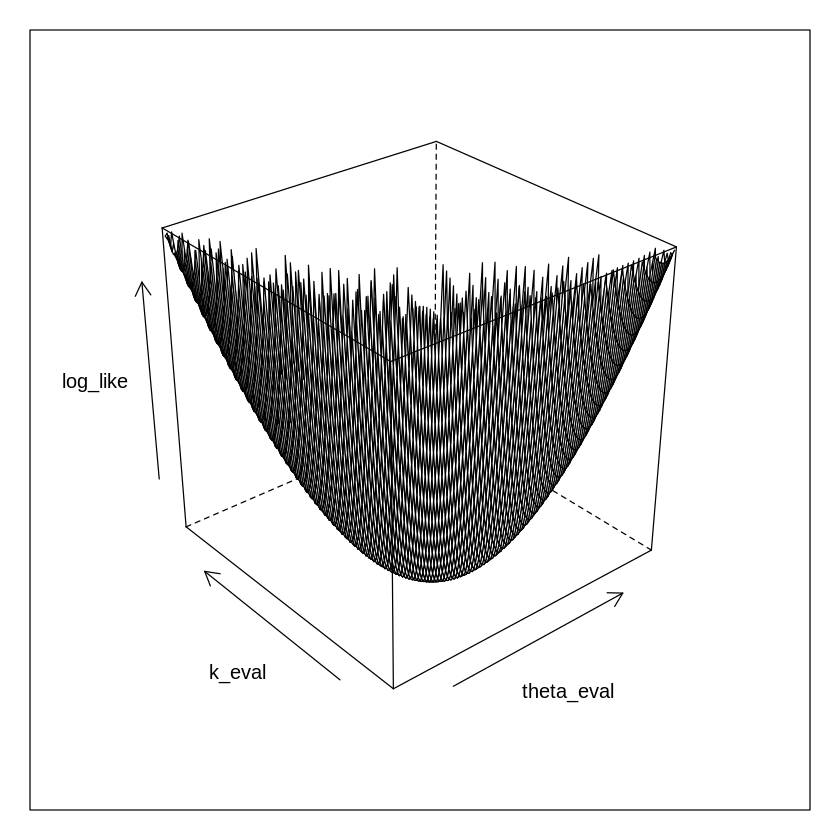

In [20]:
#check out the surface in 3D
library(lattice)
wireframe(log_like ~ theta_eval * k_eval, data=profile_all_df95)

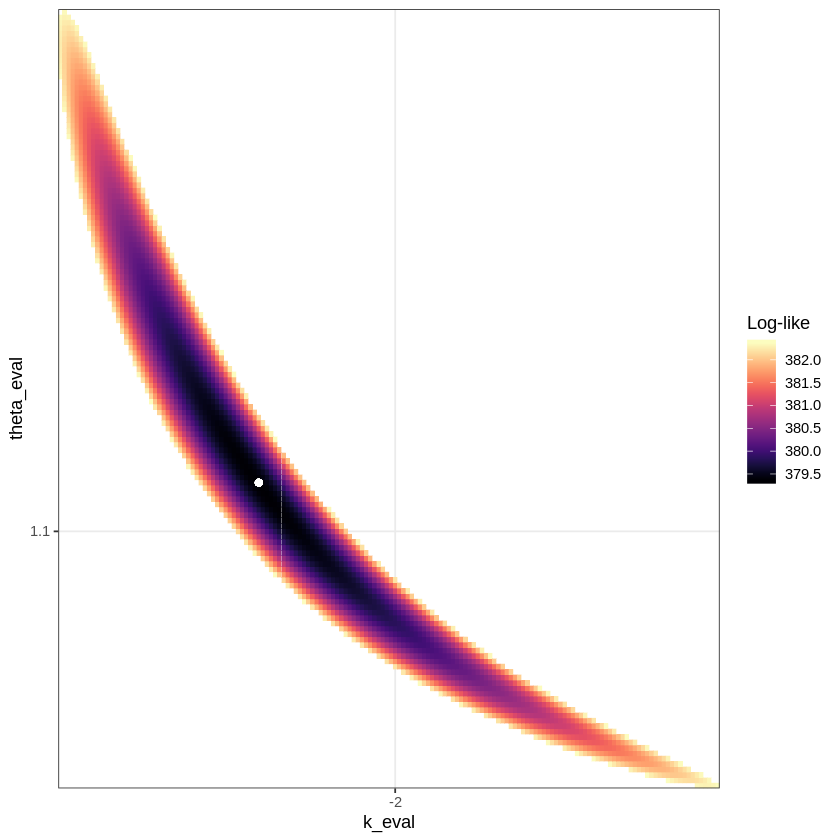

In [9]:
surfaceAll <- ggplot(profile_all_df95, aes(x = k_eval, y = theta_eval)) + 
    geom_tile(aes(fill = as.numeric(log_like), colour=as.numeric(log_like))) + 
    geom_point(aes(x = best_k_all, y = best_theta_all), colour="white") +
    scale_x_continuous(breaks = seq(-12, 12, by = 1), expand = c(0,0)) + 
    scale_y_continuous(breaks = seq(0.1, 8, by = 1), expand = c(0,0)) +
    scale_fill_viridis(option="magma", name="Log-like") + 
    scale_color_viridis(option="magma", name="Log-like") + 
    theme_bw() #+ 
    #stat_contour(aes(z = log_like), breaks = cutoff12, colour="white") 
surfaceAll
#ggplot2::ggsave(filename="surface_withCI12Years.pdf",  plot=surface12, path="~/parentage/kernel_fitting/1340_loci/final_results", dpi="print")



In [86]:
#get a distribution of MDD from the combinations of theta and k that are below the cutoff for LL
mdd14 <- cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=best_k_14, theta=best_theta_14, , method = "pcubature")$integral


profile_14_df95 <- profile_14_df %>% 
        filter(log_like < cutoff_14) 
col= "mdd"
mdd14_df <- as.data.frame(matrix(nrow=nrow(profile_14_df95), ncol=1))
colnames(mdd14_df) <- col


start <- Sys.time()
for(i in 1:nrow(profile_14_df95)){
    
    k_eval <- as.numeric(profile_14_df95$k_eval)[i]
    theta_eval <- as.numeric(profile_14_df95$theta_eval)[i]
    mdd_eval <-  as.data.frame(as.matrix(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k_eval, theta=theta_eval, relTol = 1e-05,  method = "pcubature")$integral))
    mdd14_df[i,] <-  mdd_eval
    
    }
mdd14_df <- bind_cols(profile_14_df95, mdd14_df)
end <- Sys.time()
end-start
write.csv(mdd14_df, file="~/parentage/kernel_fitting/1340_loci/final_results/mean_disp_dist/MeanDispDist95CI_2014.csv", quote=FALSE, row.names=F )



Time difference of 1.562878 mins

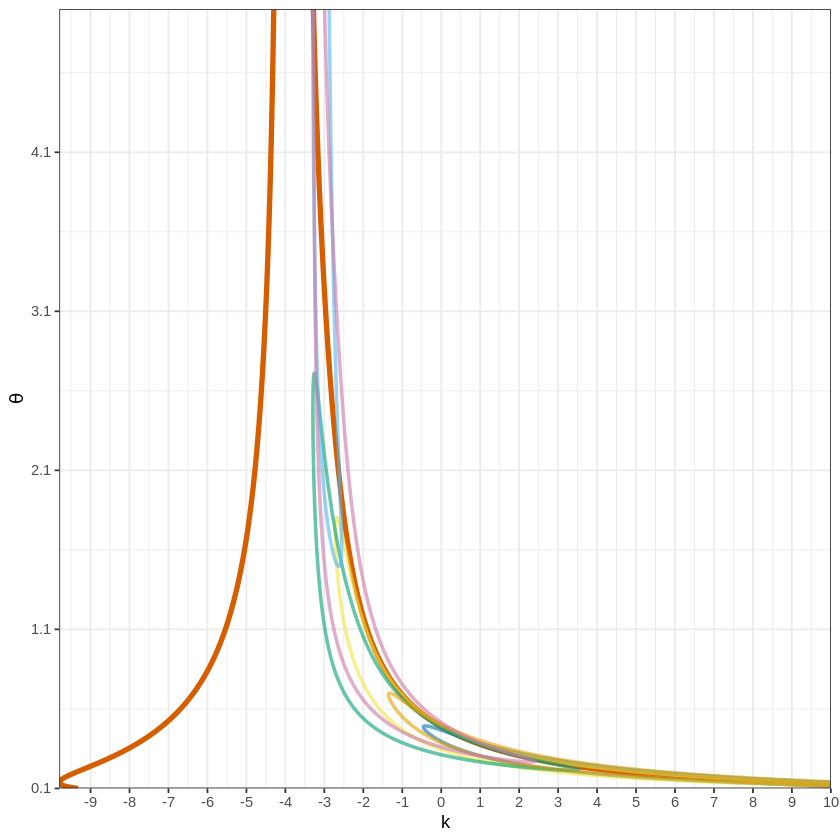

In [64]:
cbbPalette <- c("#D55E00", "#0072B2", "#F0E442", "#009E73", "#56B4E9", "#E69F00", "#CC79A7") 


stat_contour <- ggplot(data=profile_12_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(x=k_eval, y=theta_eval)) +
    stat_contour(aes(z = log_like), breaks = cutoff_12, size=1.5, colour="#D55E00") +
    stat_contour(data=profile_13_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_13, size=1, colour="#0072B2", alpha= 0.6) +
    stat_contour(data=profile_14_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_14, size=1, colour="#F0E442", alpha= 0.6) +
    stat_contour(data=profile_15_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_15, size=1, colour="#009E73", alpha= 0.6) +
    stat_contour(data=profile_16_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_16, size=1, colour="#56B4E9", alpha= 0.6) +
    stat_contour(data=profile_17_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_17, size=1, colour="#E69F00", alpha= 0.6) +
    stat_contour(data=profile_18_df %>% filter(theta_eval <= 5 & k_eval <=10), aes(z = log_like), breaks = cutoff_18, size=1, colour="#CC79A7", alpha= 0.6) +
    scale_x_continuous(breaks = seq(-10, 10, by = 1), expand = c(0, 0)) + 
    scale_y_continuous(breaks = seq(0.1, 5.3, by = 1), expand = c(0, 0)) +
    theme(legend.title=element_blank(),
    axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
    xlab("k") + ylab(expression(theta)) +
    theme_bw()




#ggplot2::ggsave(filename="All95CISurfacesCombined_contour.png",  plot=stat_contour, path="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/")
stat_contour











In [65]:
ggplot2::ggsave(filename="All95CISurfacesCombined_contour.png",  plot=stat_contour, path="~/parentage/kernel_fitting/1340_loci/final_results/likelihood_profiles_grid_search/")


Saving 6.67 x 6.67 in image


In [92]:
max(mdd15_df)

[1] 240.4633

In [111]:
head(mdd12_df %>% filter(mdd <0))
mdd13_df %>% filter(mdd <0)

mdd14_df %>% filter(mdd <0)
mdd15_df %>% filter(mdd <0)
mdd16_df %>% filter(mdd <0)
mdd17_df %>% filter(mdd <0)
mdd18_df %>% filter(mdd <0)
min(mdd14_df, na.rm = T)

k_eval,theta_eval,log_like,mdd
3.38,0.1,22.75909,-4.418869e+11
3.39,0.1,22.75856,-1.420188e+12
3.40,0.1,22.75802,-2.350120e+12
3.41,0.1,22.75749,-3.233867e+12
3.42,0.1,22.75695,-4.073517e+12
3.43,0.1,22.75641,-4.871066e+12


k_eval,theta_eval,log_like,mdd


k_eval,theta_eval,log_like,mdd


k_eval,theta_eval,log_like,mdd


k_eval,theta_eval,log_like,mdd


k_eval,theta_eval,log_like,mdd


k_eval,theta_eval,log_like,mdd


[1] -2.71

## make summary table, write it to csv for loading back in later

In [115]:
years <- c("2012", "2013","2014","2015", "2016",  "2017",  "2018","2012-2018")
k <- c(best_k_12, best_k_13, best_k_14, best_k_15, best_k_16, best_k_17, best_k_18, best_k_all)
theta <- c(best_theta_12, best_theta_13, best_theta_14, best_theta_15, best_theta_16, best_theta_17, best_theta_18, best_theta_all)
mean_disp_dist <- c(mdd12, mdd13, mdd14, mdd15, mdd16, mdd17, mdd18, mddall)
theta_CI95_upper <- c(upper_theta_12, upper_theta_13, upper_theta_14, upper_theta_15, upper_theta_16, upper_theta_17, upper_theta_18, upper_theta_all)
theta_CI95_lower <- c(lower_theta_12, lower_theta_13,lower_theta_14, lower_theta_15, lower_theta_16, lower_theta_17, lower_theta_18, lower_theta_all)
k_CI95_upper <- c(upper_k_12, upper_k_13,upper_k_14, upper_k_15, upper_k_16, upper_k_17, upper_k_18, upper_k_all)
k_CI95_lower <- c(lower_k_12, lower_k_13,lower_k_14, lower_k_15, lower_k_16, lower_k_17, lower_k_18, lower_k_all)
mdd_lower <- c(min(mdd12_df$mdd), min(mdd13_df$mdd), min(mdd14_df$mdd),min(mdd15_df$mdd),min(mdd16_df$mdd),min(mdd17_df$mdd) ,min(mdd18_df$mdd), min(mddall_df$mdd))
mdd_upper <- c(max(mdd12_df$mdd), max(mdd13_df$mdd),max(mdd14_df$mdd),max(mdd15_df$mdd),max(mdd16_df$mdd),max(mdd17_df$mdd),max(mdd18_df$mdd), max(mddall_df$mdd)) 
n_par <- c(n_par_12, n_par_13, n_par_14, n_par_15, n_par_16, n_par_17, n_par_18, n_par_all)
n_offs <- c(n_offs_12, n_offs_13, n_offs_14, n_offs_15, n_offs_16, n_offs_17, n_offs_18, n_offs_all)


kernel_fitting_summary <- as.data.frame(matrix(nrow=length(years), ncol=12))
#continue here
col <- c("Year", "best_k", "best_theta", "k_CI95_lower","k_CI95_upper", "theta_CI95_lower", "theta_CI95_upper", "MeanDispDist","MeanDispDist_CI95_lower",  "MeanDispDist_CI95_upper", "NumParentageMatches", "NumOffsSampled")
colnames(kernel_fitting_summary) <- col

kernel_fitting_summary$Year <- years
kernel_fitting_summary$best_k <- k
kernel_fitting_summary$best_theta <- theta
kernel_fitting_summary$k_CI95_lower <- k_CI95_lower
kernel_fitting_summary$k_CI95_upper <- k_CI95_upper
kernel_fitting_summary$theta_CI95_lower <- theta_CI95_lower
kernel_fitting_summary$theta_CI95_upper <- theta_CI95_upper
kernel_fitting_summary$MeanDispDist <- mean_disp_dist
kernel_fitting_summary$MeanDispDist_CI95_lower <- mdd_lower
kernel_fitting_summary$MeanDispDist_CI95_upper <- mdd_upper
kernel_fitting_summary$NumParentageMatches <- n_par
kernel_fitting_summary$NumOffsSampled <- n_offs


kernel_fitting_summary <- kernel_fitting_summary %>%
    mutate(PercentAssigned=(NumParentageMatches/NumOffsSampled)*100) %>%
    mutate(PercentAssigned=round(PercentAssigned, digits=2)) %>%
    mutate(MeanDispDist_CI95_lower= ifelse(MeanDispDist_CI95_lower <0, 0, MeanDispDist_CI95_lower))

#write.csv(kernel_fitting_summary, file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv", quote=FALSE, row.names=FALSE )


In [116]:
kernel_fitting_summary

Year,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispDist,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,NumParentageMatches,NumOffsSampled,PercentAssigned
2012,-2.36,1.03,-7.22,-1.90,0.48,1.10,10.165094,0.000000,1.367946e+26,3,63,4.76
2013,4.04,0.22,3.59,4.06,0.20,0.24,69.586280,7.978681,1.233879e+05,21,150,14.00
2014,0.49,0.38,-0.26,0.81,0.37,0.40,15.037515,5.646667,2.204186e+05,13,181,7.18
2015,-1.52,0.67,-2.08,-1.13,0.56,0.70,10.180222,6.149556,2.404633e+02,11,111,9.91
2016,-3.04,5.00,-3.07,-2.88,2.16,5.00,10.100794,7.600055,1.311733e+01,6,111,5.41
2017,2.94,0.26,2.66,3.64,0.23,0.26,29.062101,5.920487,1.172967e+04,13,130,10.00
2018,-2.32,1.37,-2.93,-2.15,1.36,1.61,7.191634,4.507346,5.079209e+01,4,45,8.89
2012-2018,-2.51,1.49,-2.51,-2.48,1.32,1.60,8.153016,7.132250,9.403629e+00,71,791,8.98
